## Setup

In [1]:
# Common imports
import numpy as np
import os

# Plot pretty
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT = "."
PROJECT_ID = "perceptron"
IMG_PATH = os.path.join(PROJECT_ROOT, "images", PROJECT_ID)
os.makedirs(IMG_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMG_PATH, fig_id + "." + fig_extension)
    print("Saving figure...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore",message="^internal gelsd")

## Get the data

In [10]:
import os
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/TuZhechen/hello_world/main/"
DATA_URL = DOWNLOAD_ROOT + "kaggles/diabetes/diabetes_prediction_dataset.csv"
LOCAL_PATH = "./diabetes"

def fetch_data(data_url=DATA_URL, local_path=LOCAL_PATH):
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    target_path = os.path.join(local_path, "diabetes.csv")
    urllib.request.urlretrieve(data_url, target_path)

In [11]:
fetch_data()

In [12]:
import pandas as pd

def load_data(local_path=LOCAL_PATH):
    csv_path = os.path.join(local_path, "diabetes.csv")
    return pd.read_csv(csv_path)

## Data review and preproc

In [13]:
diabetes = load_data()
diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [20]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float32
 2   hypertension         100000 non-null  uint8  
 3   heart_disease        100000 non-null  uint8  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float32
 6   HbA1c_level          100000 non-null  float32
 7   blood_glucose_level  100000 non-null  float32
 8   diabetes             100000 non-null  uint8  
dtypes: float32(4), object(2), uint8(3)
memory usage: 3.3+ MB


In [15]:
diabetes.smoking_history.value_counts()

No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64

In [16]:
diabetes.gender.value_counts()

Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

In [19]:
diabetes = diabetes.astype({"age": "float32", "hypertension": "uint8", "heart_disease": "uint8", "bmi": "float32", 
                 "HbA1c_level": "float32", "blood_glucose_level": "float32","diabetes": "uint8"})

In [21]:
diabetes.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.886036,0.07485,0.039420,27.321423,5.527035,138.058060,0.085000
std,22.516293,0.26315,0.194593,6.636746,1.070764,40.707127,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.629999,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690002,9.000000,300.000000,1.000000


Saving figure... attr_histo


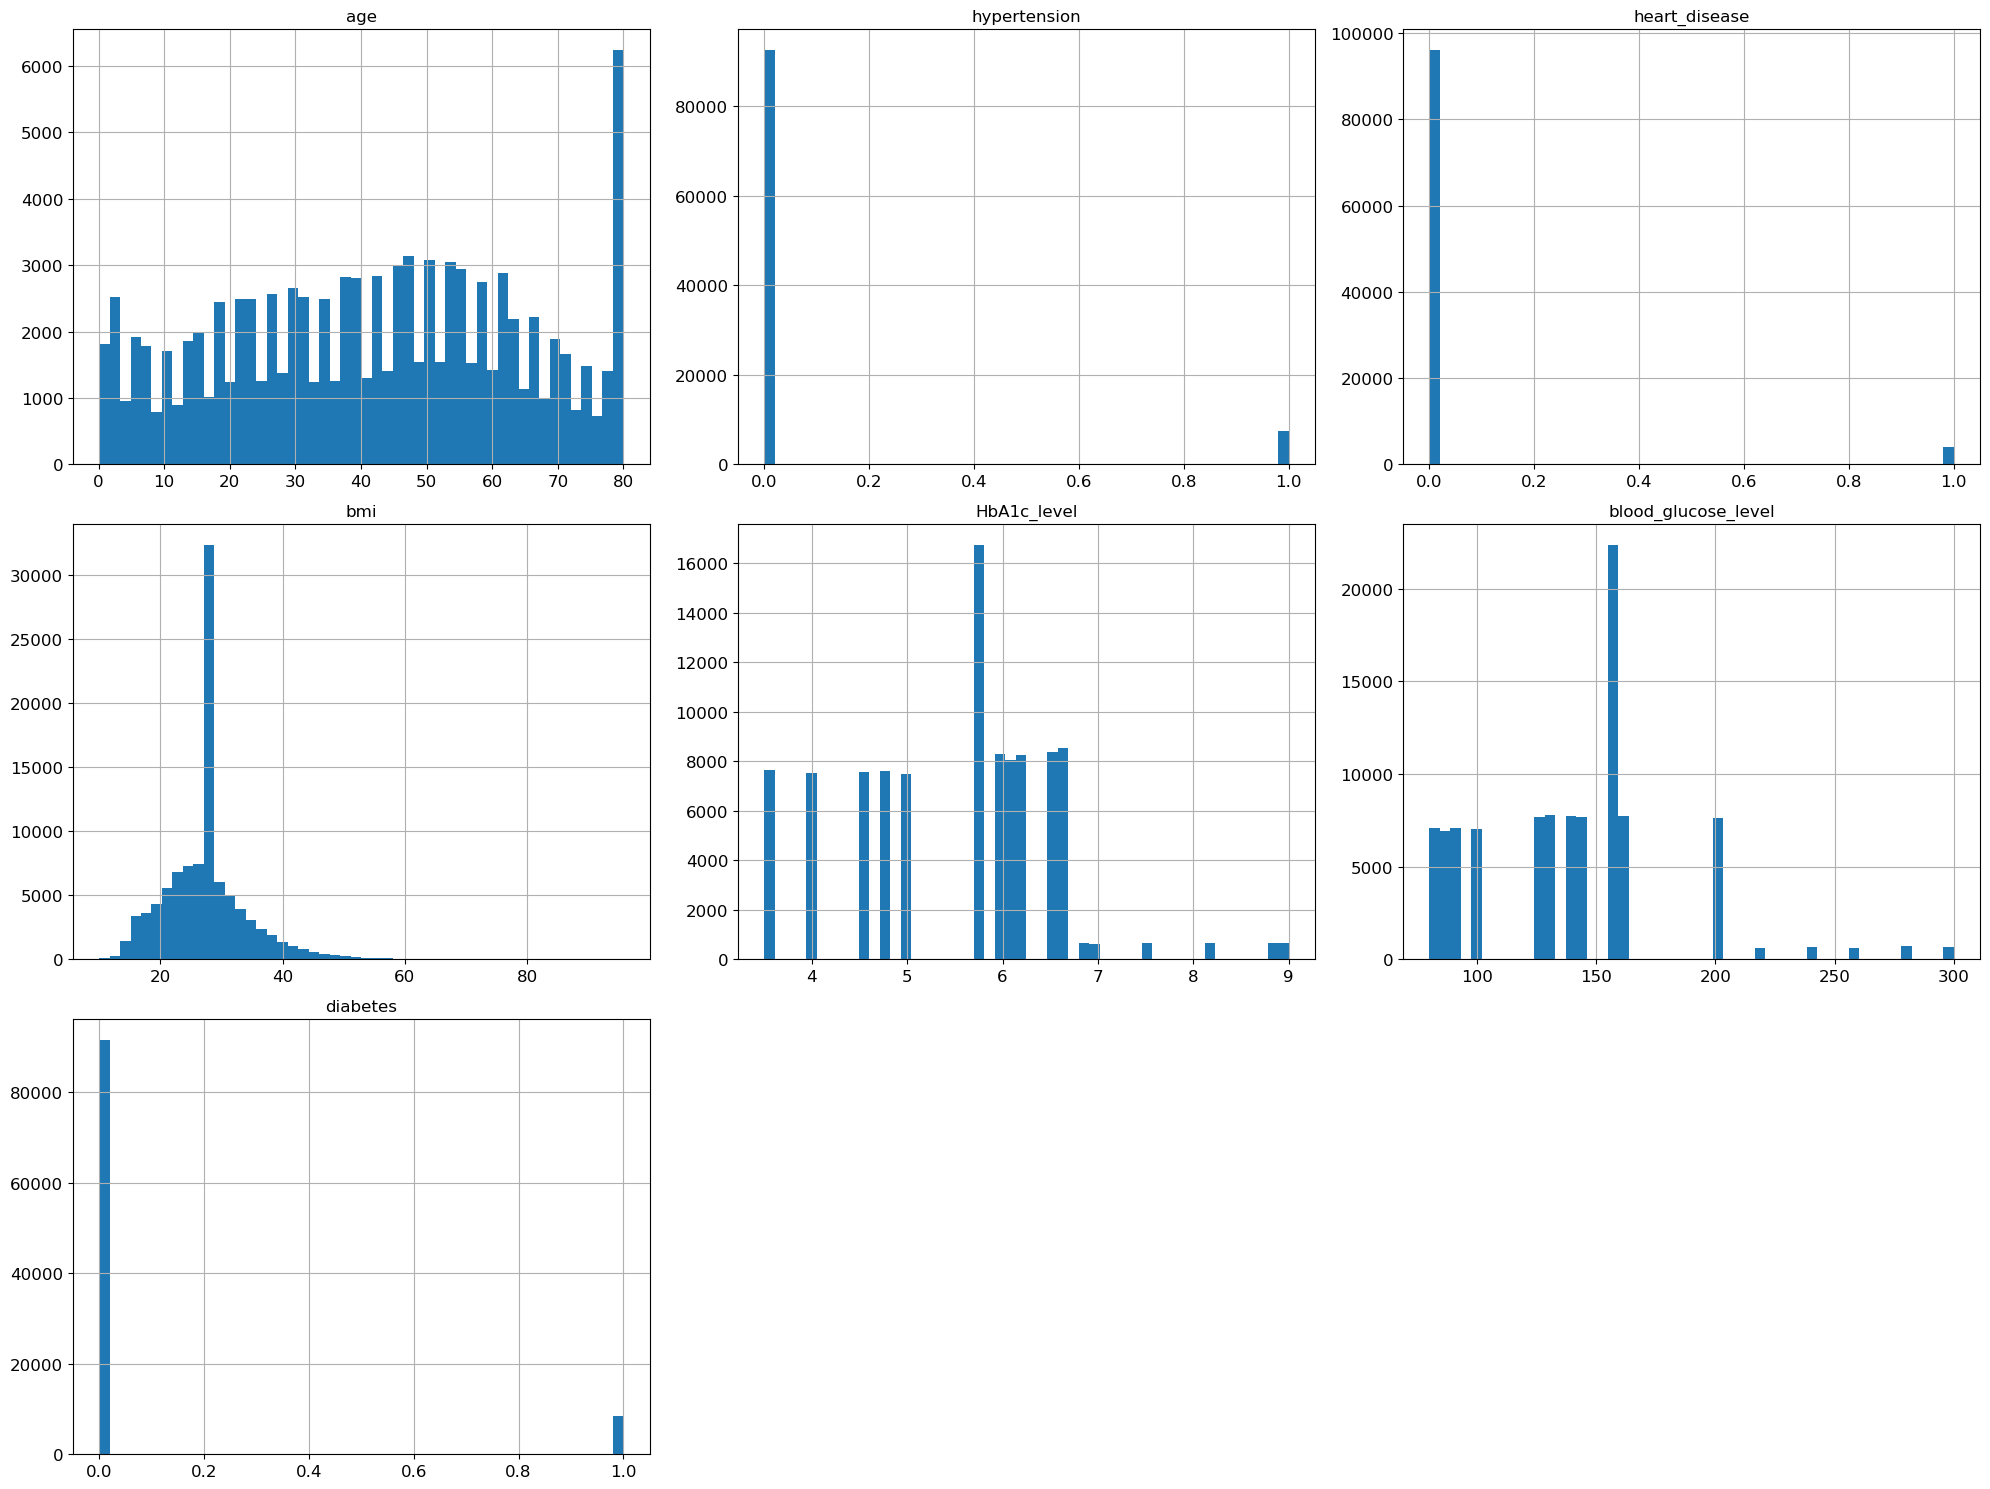

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
diabetes.hist(bins=50, figsize=(20,15))
save_fig("attr_histo")
plt.show()

## Sampling

### inital split

In [23]:
np.random.seed(42)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [24]:
init_train_set, init_test_set = split_train_test(diabetes, 0.2)
len(init_test_set)

20000

In [25]:
# Using scipy to split
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(diabetes, test_size=0.2, random_state=42)


### stratified split

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>]], dtype=object)

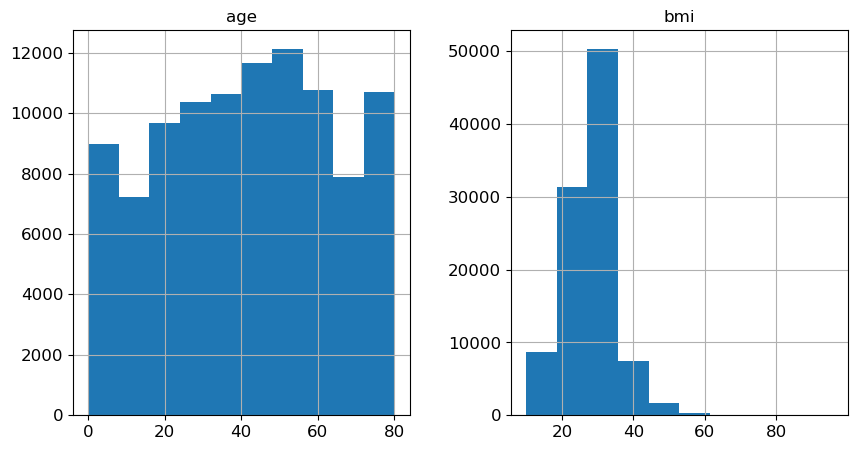

In [33]:
diabetes[["age", "bmi"]].hist(figsize=(10,5))

In [36]:
diabetes["age_group"]  = pd.cut(diabetes.age,
                             bins=[0., 20., 40., 60., 80.],
                             labels=[1, 2, 3, 4]).astype("uint8")

In [37]:
diabetes.age_group.value_counts()

3    29496
2    25968
4    23632
1    20904
Name: age, dtype: int64

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(diabetes, diabetes.age_group):
    strat_train_set = diabetes.loc[train_index]
    strat_test_set = diabetes.loc[test_index]

In [40]:
strat_test_set.age_group.value_counts() / len(strat_test_set)

3    0.29495
2    0.25970
4    0.23630
1    0.20905
Name: age_group, dtype: float64

In [42]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("age_group", axis=1, inplace=True)

## Visualization

In [43]:
diabetes = strat_train_set.copy()

Saving figure... scatter_plot_bioinfo


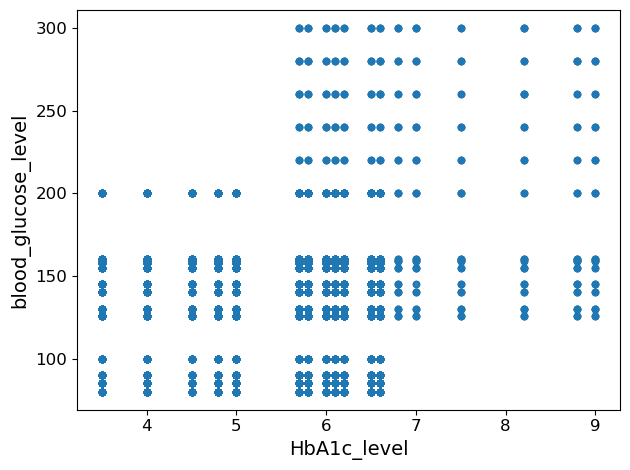

In [45]:
diabetes.plot(kind="scatter", x="HbA1c_level", y="blood_glucose_level", alpha=0.1)
save_fig("scatter_plot_bioinfo")

Saving figure... diabetes_scatterplot


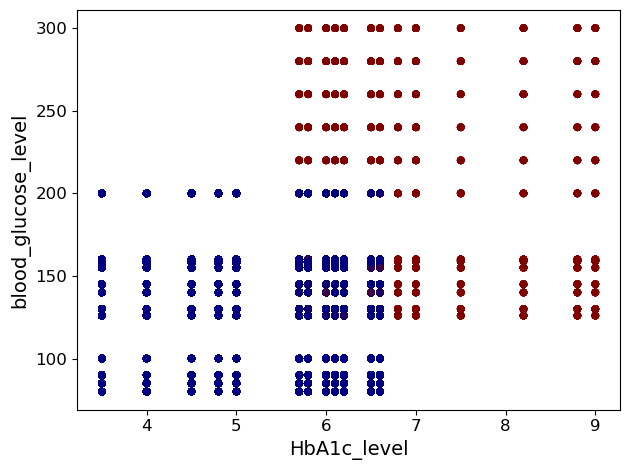

In [49]:
diabetes.plot(kind="scatter", x="HbA1c_level", y="blood_glucose_level", alpha=0.4,
    c="diabetes", cmap=plt.get_cmap("jet"), colorbar=False,
    sharex=False)
save_fig("diabetes_scatterplot")

## Prepare for ML algorithms

In [87]:
x_train = strat_train_set.drop("diabetes", axis=1)
y_train = strat_train_set["diabetes"].copy()

In [121]:
x_cat = x_train[["gender", "smoking_history"]]
x_cat.head(10)

,gender,smoking_history
7924,Male,No Info
20211,Male,No Info
79993,Female,not current
90862,Male,never
88187,Male,No Info
52938,Male,No Info
9443,Male,No Info
89347,Male,not current
35895,Male,never
16111,Male,No Info


In [122]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

gender_encoded = ordinal_encoder.fit_transform(x_cat.iloc[:, 0].values.reshape(-1,1))
x_cat.loc[:, "gender"] = gender_encoded.flatten()
x_cat.head(10)

C:\Users\10341\AppData\Local\Temp\ipykernel_12188\711096872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_cat.loc[:, "gender"] = gender_encoded.flatten()


,gender,smoking_history
7924,1.0,No Info
20211,1.0,No Info
79993,0.0,not current
90862,1.0,never
88187,1.0,No Info
52938,1.0,No Info
9443,1.0,No Info
89347,1.0,not current
35895,1.0,never
16111,1.0,No Info


In [123]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
smoking_history_encoded = one_hot_encoder.fit_transform(x_cat.iloc[:, 1].values.reshape(-1,1))
smoking_history_encoded

<80000x6 sparse matrix of type '<class 'numpy.float64'>'
	with 80000 stored elements in Compressed Sparse Row format>

In [124]:
one_hot_encoder.categories_

[array(['No Info', 'current', 'ever', 'former', 'never', 'not current'],
       dtype=object)]

In [125]:
smoking_history_encoded.toarray()

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [126]:
smoking_history_encoded.columns = one_hot_encoder.get_feature_names(["smoking"])
smoking_history = pd.DataFrame(smoking_history_encoded.todense(), columns=smoking_history_encoded.columns)
smoking_history = smoking_history.set_index(x_cat.index)
smoking_history.head()

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,smoking_No Info,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_not current
7924,1.0,0.0,0.0,0.0,0.0,0.0
20211,1.0,0.0,0.0,0.0,0.0,0.0
79993,0.0,0.0,0.0,0.0,0.0,1.0
90862,0.0,0.0,0.0,0.0,1.0,0.0
88187,1.0,0.0,0.0,0.0,0.0,0.0


In [127]:
x_cat = pd.concat([x_cat, smoking_history], axis=1)
x_cat.drop("smoking_history", axis=1, inplace=True)
x_cat.head(10)

,gender,smoking_No Info,smoking_current,smoking_ever,smoking_former,smoking_never,smoking_not current
7924,1.0,1.0,0.0,0.0,0.0,0.0,0.0
20211,1.0,1.0,0.0,0.0,0.0,0.0,0.0
79993,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90862,1.0,0.0,0.0,0.0,0.0,1.0,0.0
88187,1.0,1.0,0.0,0.0,0.0,0.0,0.0
52938,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9443,1.0,1.0,0.0,0.0,0.0,0.0,0.0
89347,1.0,0.0,0.0,0.0,0.0,0.0,1.0
35895,1.0,0.0,0.0,0.0,0.0,1.0,0.0
16111,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [128]:
x_cat = x_cat.astype({"gender": "uint8", "smoking_No Info": "uint8", "smoking_current": "uint8", 
                 "smoking_ever": "uint8", "smoking_former": "uint8","smoking_never": "uint8", "smoking_not current": "uint8"})
x_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 7924 to 84037
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   gender               80000 non-null  uint8
 1   smoking_No Info      80000 non-null  uint8
 2   smoking_current      80000 non-null  uint8
 3   smoking_ever         80000 non-null  uint8
 4   smoking_former       80000 non-null  uint8
 5   smoking_never        80000 non-null  uint8
 6   smoking_not current  80000 non-null  uint8
dtypes: uint8(7)
memory usage: 3.2 MB


In [132]:
x_cat = pd.concat([x_cat, x_train[["hypertension", "heart_disease"]]], axis=1)

In [134]:
x_num = x_train.drop(["hypertension", "heart_disease", "gender", "smoking_history"], axis=1)
x_num.head()

,age,bmi,HbA1c_level,blood_glucose_level
7924,15.0,26.34,3.5,140.0
20211,44.0,27.32,4.0,159.0
79993,47.0,28.90,4.8,85.0
90862,8.0,15.07,5.8,90.0
88187,14.0,20.59,4.8,159.0


In [135]:
y_train.head()

7924     0
20211    0
79993    0
90862    0
88187    0
Name: diabetes, dtype: uint8

## SGD from scratch

In [144]:
import numpy as np

class SGD:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs
    
    def fit(self, X, y):
        self.weight = np.zeros(X.shape[1])
        self.bias = 0

        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                perceptor_i = y[i] * (np.dot(self.weight, X[i]) + self.bias)
                if perceptor_i <= 0:
                    self.weight += self.learning_rate * y[i] * X[i]
                    self.bias += self.learning_rate * y[i]
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0], dtype=np.int8)
        for i in range(X.shape[0]):
            if np.dot(self.weight, X[i]) + self.bias > 0:
                y_pred[i] = 1
            else:
                y_pred[i] = -1
        return y_pred

In [155]:
y_train = y_train.astype("int8").replace(0, -1)
sgd = SGD()
sgd.fit(x_num.values, y_train.values.ravel())

In [156]:
print('Weights:', sgd.weight)
print('Bias:', sgd.bias)

Weights: [ 1.41072455  2.18106485 66.88013031  1.70294017]
Bias: -865.4499999993579


In [157]:
x_test = strat_test_set.drop("diabetes", axis=1)
x_test_num = x_test.drop(["hypertension", "heart_disease", "gender", "smoking_history"], axis=1)
y_test = strat_test_set["diabetes"].copy()
y_test = y_test.astype("int8").replace(0, -1)
y_pred = sgd.predict(x_test_num.values)

In [160]:
error_rate = np.mean(y_pred != y_test.values)
print("Misclassified: ", error_rate)

Misclassified:  0.057


In [181]:
class SGD_Moment(SGD):
    def __init__(self, learning_rate=0.1, epochs=100, momentum=0.9, epsilon=1e-3):
        super().__init__(learning_rate, epochs)
        self.momentum = momentum
        self.epsilon = epsilon

    def fit(self, X, y):
        self.weight = np.zeros(X.shape[1])
        v_w = self.weight
        prev_w = self.weight.copy()
        self.bias = 0
        v_b = self.bias
        prev_b = self.bias

        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                perceptor_i = y[i] * (np.dot(self.weight, X[i]) + self.bias)
                if perceptor_i <= 0:
                    v_w = self.momentum * v_w - y[i] * X[i]
                    v_b = self.momentum * v_b - y[i]
                    self.weight -= self.learning_rate * v_w
                    self.bias -= self.learning_rate * v_b
            if np.linalg.norm(self.weight - prev_w) < self.epsilon and abs(self.bias - prev_b) < self.epsilon:
                break
            prev_w = self.weight.copy()
            prev_b = self.bias

In [182]:
sgd_moment = SGD_Moment()
sgd_moment.fit(x_num.values, y_train.values.ravel())

In [183]:
print('Weights(Momentum fit):', sgd_moment.weight)
print('Bias(Momentum fit):', sgd_moment.bias)

Weights(Momentum fit): [  58.73677174  102.40505317 3668.47113014   52.08839126]
Bias(Momentum fit): -46374.1065710263


In [184]:
y_pred_m = sgd_moment.predict(x_test_num.values)
error_rate = np.mean(y_pred_m != y_test.values)
print("Misclassified(Momentum fit): ", error_rate)

Misclassified(Momentum fit):  0.06555


## LR scheduler from scratch

In [185]:
class StepLR:
    def __init__(self, optimizer, step_size, gamma=0.1):
        self.optimizer = optimizer
        self.step_size = step_size
        self.gamma = gamma
        self.last_epoch = 0
    
    def step(self):
        if (self.last_epoch + 1) % self.step_size == 0:
            self.optimizer.learning_rate *= self.gamma
        self.last_epoch += 1

In [214]:
class CosineAnnealingLR:
    def __init__(self, optimizer, T_max, eta_min=0) -> None:
        self.optimizer = optimizer
        self.T_max = T_max
        self.eta_min = eta_min
        self.last_epoch = 0
    
    def step(self):
        self.optimizer.learning_rate = self.eta_min \
        + (self.optimizer.learning_rate - self.eta_min) \
        * (1 + np.cos(np.pi * self.last_epoch / self.T_max))/2
        self.last_epoch += 1

In [206]:
class SGD_Base:
    def __init__(self, learning_rate=0.01, epochs=100, epsilon=1e-3):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.epsilon = epsilon
    
    def fit(self, X, y):
        self.weight = np.zeros(X.shape[1])
        self.bias = 0
        prev_w = self.weight.copy()
        prev_b = self.bias

        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
                perceptor_i = y[i] * (np.dot(self.weight, X[i]) + self.bias)
                if perceptor_i <= 0:
                    self.weight += self.learning_rate * y[i] * X[i]
                    self.bias += self.learning_rate * y[i]
                    
            if np.linalg.norm(self.weight - prev_w) < self.epsilon and abs(self.bias - prev_b) < self.epsilon:
                break
            prev_w = self.weight.copy()
            prev_b = self.bias
        
            if hasattr(self, 'scheduler'):
                self.scheduler.step()
    
    def predict(self, X):
        y_pred = np.zeros(X.shape[0], dtype=np.int8)
        for i in range(X.shape[0]):
            if np.dot(self.weight, X[i]) + self.bias > 0:
                y_pred[i] = 1
            else:
                   y_pred[i] = -1
        return y_pred

In [207]:
class SGD_StepLR(SGD_Base):
    def __init__(self, learning_rate=0.01, epochs=100, epsilon=1e-3):
        super().__init__(learning_rate, epochs, epsilon)
        self.scheduler = StepLR(self, step_size=20, gamma=0.1)

In [208]:
sgd_steplr = SGD_StepLR()
sgd_steplr.fit(x_num.values, y_train.values)

In [209]:
print('Weights(StepLR): ', sgd_steplr.weight)
print('Bias(StepLR): ', sgd_steplr.bias)
print('Learning Rate: ', sgd_steplr.learning_rate)

Weights(StepLR):  [ 0.51563173  1.07187836 27.10848101  0.29845539]
Bias(StepLR):  -288.7997470001374
Learning Rate:  1.0000000000000002e-06


In [210]:
y_pred_stepLR = sgd_steplr.predict(x_test_num.values)
error_rate = np.mean(y_pred_stepLR != y_test.values)
print("Misclassified(StepLR): ", error_rate)

Misclassified(StepLR):  0.0494


In [211]:
class SGD_CosineAnnealingLR(SGD_Base):
    def __init__(self, learning_rate=0.01, epochs=100, epsilon=1e-3):
        super().__init__(learning_rate, epochs, epsilon)
        self.scheduler = CosineAnnealingLR(self, T_max=30)

In [215]:
sgd_cos = SGD_CosineAnnealingLR()
sgd_cos.fit(x_num.values, y_train.values)

In [216]:
print('Weights(CosineAnnealingLR): ', sgd_cos.weight)
print('Bias(CosineAnnealingLR): ', sgd_cos.bias)
print('Learning Rate: ', sgd_cos.learning_rate)

Weights(CosineAnnealingLR):  [ 0.31602329  0.64747704 12.23663792  0.17377187]
Bias(CosineAnnealingLR):  -147.51791956610185
Learning Rate:  2.419063292898559e-07


In [217]:
y_pred_cos = sgd_cos.predict(x_test_num.values)
error_rate = np.mean(y_pred_cos != y_test.values)
print("Misclassified(ConsineAnnelingLR): ", error_rate)

Misclassified(ConsineAnnelingLR):  0.0482
